
# РАЗДЕЛ 1: ИМПОРТ БИБЛИОТЕК


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (classification_report, confusion_matrix, recall_score,
                             f1_score, roc_auc_score, roc_curve)

from catboost import CatBoostClassifier
import joblib

sns.set(style='whitegrid')
print("✓ Все библиотеки загружены")

✓ Все библиотеки загружены



# РАЗДЕЛ 2: ЗАГРУЗКА ДАННЫХ


In [2]:

try:
    heart_train = pd.read_csv(r'Проект Сердце\heart_test.csv', sep=",", decimal='.', low_memory=False)
except Exception:
    heart_train = pd.read_csv(r'heart_train.csv', sep=",", decimal='.', low_memory=False)

print('✓ Данные загружены. Форма:', heart_train.shape)
display(heart_train.head(3))

✓ Данные загружены. Форма: (8685, 28)


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379


# РАЗДЕЛ 3: ПРЕДОБРАБОТКА

In [3]:
df = heart_train.copy()

# Удаление служебных столбцов
for c in ['Unnamed: 0', 'id']:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

# Преобразуем Gender в числовой формат
if 'Gender' in df.columns:
    df['Gender'] = df['Gender'].astype(str)
    def clean_gender(val):
        if val.lower() in ['male', 'm', '1', '1.0']:
            return 1
        if val.lower() in ['female', 'f', '0', '0.0']:
            return 0
        return np.nan
    df['Gender'] = df['Gender'].apply(clean_gender)

# Разделение на признаки и цель
TARGET = 'Heart Attack Risk (Binary)'
if TARGET not in df.columns:
    raise ValueError(f"Целевая колонка '{TARGET}' не найдена")

X = df.drop(columns=[TARGET])
y = df[TARGET]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('✓ Разделение выполнено:')
print('  X_train:', X_train.shape, 'X_test:', X_test.shape)

✓ Разделение выполнено:
  X_train: (6948, 25) X_test: (1737, 25)


# РАЗДЕЛ 4: ОПРЕДЕЛЕНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

In [4]:
# Автоопределение категориальных колонок
cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object' or X_train[c].nunique() <= 10]
cat_cols = [c for c in cat_cols if c in X_train.columns]

print('Категориальные признаки (авто):', cat_cols)

# ⭐ ВАЖНО: Приведём категориальные признаки к типу STRING (не float, не int)
# Это необходимо для CatBoost
for c in cat_cols:
    X_train[c] = X_train[c].astype(str)
    X_test[c] = X_test[c].astype(str)

# Индексы категориальных колонок для CatBoost
cat_feature_idx = [X_train.columns.get_loc(c) for c in cat_cols]

print('Индексы категориальных признаков:', cat_feature_idx)
print('✓ Подготовка категориальных признаков завершена (преобразованы в строки)')

Категориальные признаки (авто): ['Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Gender']
Индексы категориальных признаков: [3, 4, 5, 6, 7, 9, 10, 11, 12, 17, 18, 22]
✓ Подготовка категориальных признаков завершена (преобразованы в строки)


# РАЗДЕЛ 5: БЫСТРЫЙ ОТБОР ПРИЗНАКОВ (SelectFromModel)

In [5]:
print("Обучаем лёгкую CatBoost (может занять минуту) ...")

cb_light = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    verbose=0,
    random_state=42
)

cb_light.fit(X_train, y_train, cat_features=cat_feature_idx)

importances = cb_light.get_feature_importance()
imp_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances}).sort_values('importance', ascending=False)

print('\nТоп-20 признаков (по importance):')
print(imp_df.head(20).to_string(index=False))

# SelectFromModel: threshold='median'
sfm = SelectFromModel(cb_light, prefit=True, threshold='median')
mask = sfm.get_support()
selected = X_train.columns[mask].tolist()

MIN_FEATURES = 10
if len(selected) < MIN_FEATURES:
    selected = imp_df['feature'].head(max(MIN_FEATURES, len(selected))).tolist()

print('\nВыбрано признаков:', len(selected))
print('Список:', selected)

X_train_best = X_train[selected].copy()
X_test_best = X_test[selected].copy()
print('\nX_train_best shape:', X_train_best.shape)
print('X_test_best shape:', X_test_best.shape)

Обучаем лёгкую CatBoost (может занять минуту) ...

Топ-20 признаков (по importance):
                        feature  importance
                 Medication Use    8.847139
        Systolic blood pressure    6.566301
                  Triglycerides    6.531980
                    Cholesterol    6.426598
                     Heart rate    6.416416
                            Age    6.378694
                            BMI    6.320150
        Sedentary Hours Per Day    5.849408
                         Income    5.503992
        Exercise Hours Per Week    5.129257
                        Obesity    4.583976
        Previous Heart Problems    4.081688
       Diastolic blood pressure    3.709569
Physical Activity Days Per Week    3.539185
            Sleep Hours Per Day    2.989871
            Alcohol Consumption    2.690962
                        Smoking    2.345108
                       Troponin    2.213900
                          CK-MB    1.809377
                       Diabetes    

# РАЗДЕЛ 6: РАСЧЁТ ВЕСОВ КЛАССОВ И GRIDSEARCH

In [6]:
# ⭐ ВАЖНО: пересчитываем индексы категориальных признаков для X_train_best
cat_feature_idx_best = []
for c in cat_cols:
    if c in X_train_best.columns:
        idx = X_train_best.columns.get_loc(c)
        cat_feature_idx_best.append(idx)

print('Категориальные признаки в X_train_best:', [X_train_best.columns[i] for i in cat_feature_idx_best])
print('Новые индексы:', cat_feature_idx_best)

# Расчёт весов классов
class_counts = y_train.value_counts().sort_index()
total = class_counts.sum()
if 0.0 in class_counts.index and 1.0 in class_counts.index:
    weight_for_0 = total / (2.0 * class_counts[0.0])
    weight_for_1 = total / (2.0 * class_counts[1.0])
    class_weights = [weight_for_0, weight_for_1]
else:
    class_weights = None

print('Веса классов:', class_weights)

# Подготовка GridSearch
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

catboost_est = CatBoostClassifier(
    verbose=0,
    random_state=42,
    loss_function='Logloss',
    eval_metric='F1',
    early_stopping_rounds=50,
    class_weights=class_weights
)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [500]
}

print('\nЗапуск GridSearchCV (может занять время) ...')
grid_search = GridSearchCV(
    estimator=catboost_est,
    param_grid=param_grid,
    cv=skf,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# ⭐ передаём НОВЫЕ индексы для X_train_best
grid_search.fit(X_train_best, y_train, **{'cat_features': cat_feature_idx_best})

print('\nGridSearch завершён')
print('Лучшие параметры:', grid_search.best_params_)
print(f'Лучший CV f1: {grid_search.best_score_:.4f}')

Категориальные признаки в X_train_best: ['Obesity', 'Previous Heart Problems', 'Medication Use']
Новые индексы: [3, 5, 6]
Веса классов: [np.float64(0.7655354781842221), np.float64(1.44149377593361)]

Запуск GridSearchCV (может занять время) ...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

GridSearch завершён
Лучшие параметры: {'depth': 4, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.01}
Лучший CV f1: 0.4754


# РАЗДЕЛ 7: ОЦЕНКА И ОПТИМИЗАЦИЯ ПОРОГА

Отчёт по классификации при пороге 0.5:
              precision    recall  f1-score   support

         0.0       0.70      0.35      0.46      1134
         1.0       0.37      0.72      0.49       603

    accuracy                           0.48      1737
   macro avg       0.53      0.53      0.48      1737
weighted avg       0.58      0.48      0.47      1737

Чувствительность: 0.7181, Специфичность: 0.3474, F1: 0.4876

Оптимальный порог: 0.51
После оптимизации: Recall=0.5008, Specificity=0.5423, F1=0.4242


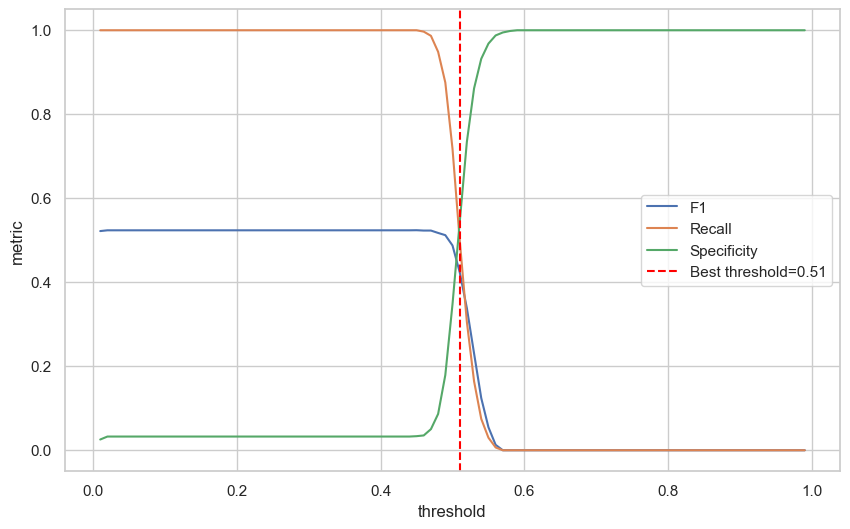

In [7]:
best_cb = grid_search.best_estimator_

y_probs = best_cb.predict_proba(X_test_best)[:, 1]
y_pred_default = best_cb.predict(X_test_best)

def calculate_specificity(y_true, y_pred):
    try:
        cm = confusion_matrix(y_true, y_pred)
        TN = cm[0, 0]
        FP = cm[0, 1]
        return TN / (TN + FP)
    except Exception:
        return 0.0

print('Отчёт по классификации при пороге 0.5:')
print(classification_report(y_test, y_pred_default))

sens = recall_score(y_test, y_pred_default, pos_label=1)
spec = calculate_specificity(y_test, y_pred_default)
print(f'Чувствительность: {sens:.4f}, Специфичность: {spec:.4f}, F1: {f1_score(y_test, y_pred_default):.4f}')

# Поиск оптимального порога
thresholds = np.linspace(0.01, 0.99, 99)
results = []
MIN_SPECIFICITY = 0.40

for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    f1t = f1_score(y_test, y_pred_t)
    rect = recall_score(y_test, y_pred_t)
    spect = calculate_specificity(y_test, y_pred_t)
    results.append({'threshold': t, 'f1': f1t, 'recall': rect, 'specificity': spect})

res_df = pd.DataFrame(results)
filtered = res_df[res_df['specificity'] >= MIN_SPECIFICITY]

if not filtered.empty:
    best_row = filtered.loc[filtered['recall'].idxmax()]
    best_threshold = float(best_row['threshold'])
else:
    best_row = res_df.loc[res_df['f1'].idxmax()]
    best_threshold = float(best_row['threshold'])

y_pred_opt = (y_probs >= best_threshold).astype(int)
rec_opt = recall_score(y_test, y_pred_opt)
spec_opt = calculate_specificity(y_test, y_pred_opt)
f1_opt = f1_score(y_test, y_pred_opt)

print(f'\nОптимальный порог: {best_threshold}')
print(f'После оптимизации: Recall={rec_opt:.4f}, Specificity={spec_opt:.4f}, F1={f1_opt:.4f}')

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(res_df['threshold'], res_df['f1'], label='F1')
plt.plot(res_df['threshold'], res_df['recall'], label='Recall')
plt.plot(res_df['threshold'], res_df['specificity'], label='Specificity')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best threshold={best_threshold:.2f}')
plt.xlabel('threshold')
plt.ylabel('metric')
plt.legend()
plt.grid(True)
plt.show()

# РАЗДЕЛ 8: ROC AUC И ВАЖНОСТЬ ПРИЗНАКОВ

ROC AUC = 0.5404210575575972


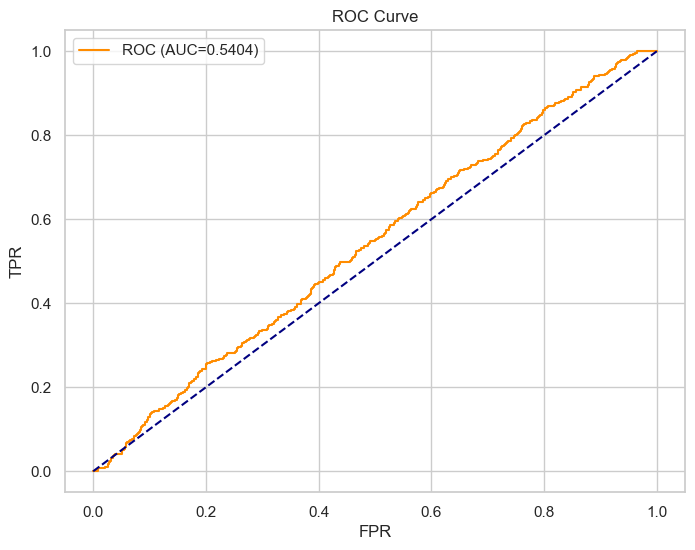


Топ-10 признаков по важности:
                feature  importance
         Medication Use   37.264164
Previous Heart Problems   24.726519
                Obesity   12.253570
Systolic blood pressure    3.955680
                    BMI    3.824552
                    Age    3.176683
            Cholesterol    2.708702
             Heart rate    2.674670
          Triglycerides    2.175796
Sedentary Hours Per Day    1.903070


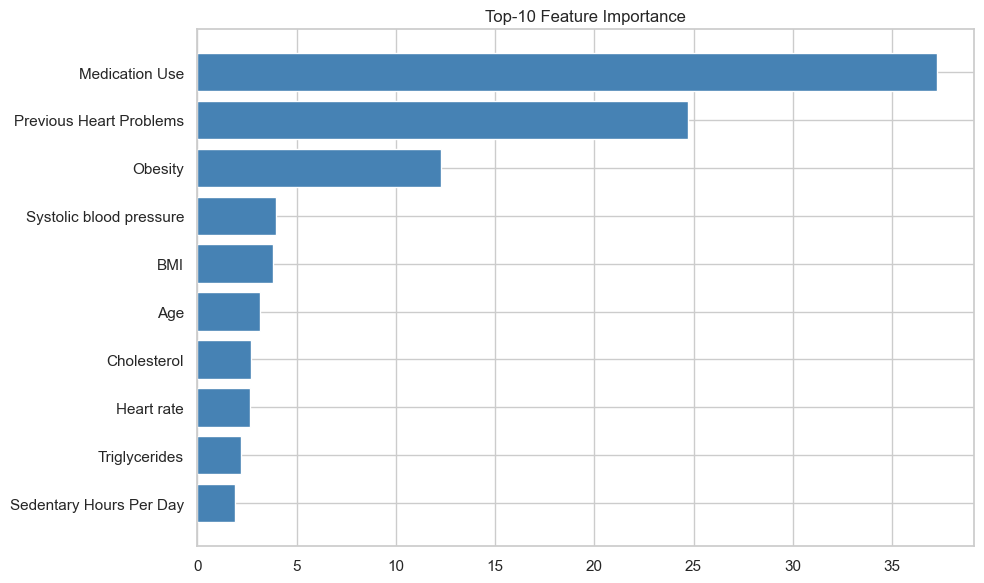

In [8]:
roc_auc = roc_auc_score(y_test, y_probs)
fpr, tpr, _ = roc_curve(y_test, y_probs)

print('ROC AUC =', roc_auc)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Важности признаков
try:
    fi = best_cb.get_feature_importance()
    fi_df = pd.DataFrame({'feature': X_train_best.columns, 'importance': fi}).sort_values('importance', ascending=False)
    print('\nТоп-10 признаков по важности:')
    print(fi_df.head(10).to_string(index=False))
    
    plt.figure(figsize=(10, 6))
    plt.barh(fi_df['feature'].head(10), fi_df['importance'].head(10), color='steelblue')
    plt.gca().invert_yaxis()
    plt.title('Top-10 Feature Importance')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Не удалось получить importance:', e)

# РАЗДЕЛ 9: СОХРАНЕНИЕ МОДЕЛИ

In [9]:
joblib.dump(grid_search.best_estimator_, 'catboost_best_model.pkl')
print("✓ Модель сохранена: catboost_best_model.pkl")

# Также сохраняем параметры для справки
params_summary = {
    'best_params': grid_search.best_params_,
    'best_cv_score': grid_search.best_score_,
    'best_threshold': best_threshold,
    'roc_auc': roc_auc,
    'selected_features': X_train_best.columns.tolist()
}
joblib.dump(params_summary, 'model_params.pkl')
print("✓ Параметры модели сохранены: model_params.pkl")

✓ Модель сохранена: catboost_best_model.pkl
✓ Параметры модели сохранены: model_params.pkl


In [ ]:
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, recall_score, precision_score

def calculate_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0,0]; FP = cm[0,1]
    return TN / (TN + FP) if (TN + FP) > 0 else 0.0

# Собираем метрики текущей модели
results_curr = {}
results_curr['cv_f1'] = getattr(grid_search, 'best_score_', None)
results_curr['best_params'] = getattr(grid_search, 'best_params_', None)

best_model = grid_search.best_estimator_
y_probs = best_model.predict_proba(X_test_best)[:,1]
y_pred_default = best_model.predict(X_test_best)

results_curr['test_f1_0.5'] = f1_score(y_test, y_pred_default)
results_curr['test_recall_0.5'] = recall_score(y_test, y_pred_default)
results_curr['test_precision_0.5'] = precision_score(y_test, y_pred_default)
results_curr['test_specificity_0.5'] = calculate_specificity(y_test, y_pred_default)
results_curr['roc_auc'] = roc_auc_score(y_test, y_probs)

# Оптимальный порог: если best_threshold вычислен выше — используем, иначе находим F1-max
try:
    best_threshold_local = best_threshold
except NameError:
    # Если не определён, найдём порог, максимизирующий F1 на тесте (быстро)
    thresholds = np.linspace(0.01, 0.99, 99)
    f1s = [(t, f1_score(y_test, (y_probs>=t).astype(int))) for t in thresholds]
    best_threshold_local = max(f1s, key=lambda x: x[1])[0]

y_pred_opt = (y_probs >= best_threshold_local).astype(int)
results_curr['best_threshold'] = best_threshold_local
results_curr['test_f1_opt'] = f1_score(y_test, y_pred_opt)
results_curr['test_recall_opt'] = recall_score(y_test, y_pred_opt)
results_curr['test_specificity_opt'] = calculate_specificity(y_test, y_pred_opt)
results_curr['test_precision_opt'] = precision_score(y_test, y_pred_opt)

# Печать аккуратно
print("=== Текущая модель — сводка ===")
print("CV F1 (GridSearch):", results_curr['cv_f1'])
print(f"ROC AUC (test): {results_curr['roc_auc']:.4f}")
print("\n-- Порог 0.5 --")
print(f"F1: {results_curr['test_f1_0.5']:.4f}, Recall: {results_curr['test_recall_0.5']:.4f}, Specificity: {results_curr['test_specificity_0.5']:.4f}, Precision: {results_curr['test_precision_0.5']:.4f}")
print(f"\n-- Оптимизированный порог = {results_curr['best_threshold']:.4f} --")
print(f"F1: {results_curr['test_f1_opt']:.4f}, Recall: {results_curr['test_recall_opt']:.4f}, Specificity: {results_curr['test_specificity_opt']:.4f}, Precision: {results_curr['test_precision_opt']:.4f}")

# Сравним с предыдущими результатами, если есть файл model_params.pkl или model_params_old.pkl
prev_candidates = ['model_params.pkl', 'model_params_old.pkl', 'model_params_prev.pkl']
prev = None
for fn in prev_candidates:
    try:
        prev = joblib.load(fn)
        print(f"\nНайден предыдущий файл метрик: {fn}")
        break
    except Exception:
        prev = None

if prev:
    print("\n=== Сравнение с предыдущими сохранёнными параметрами ===")
    # Пробуем извлечь релевантные поля из prev (без ошибки, если их нет)
    prev_cv = prev.get('best_cv_score') if isinstance(prev, dict) else None
    prev_threshold = prev.get('best_threshold') if isinstance(prev, dict) else None
    prev_roc = prev.get('roc_auc') if isinstance(prev, dict) else None
    print("Prev CV F1:", prev_cv)
    print("Prev ROC AUC:", prev_roc)
    if prev_threshold is not None:
        print("Prev best threshold:", prev_threshold)
    # Если prev содержит конкретные тестовые метрики, выведем дельты
    # (ожидаем, что prev мог хранить test metrics; попробуем безопасно)
    def safe_get(d, k): return d.get(k) if isinstance(d, dict) else None
    pv_f1 = safe_get(prev, 'test_f1_opt') or safe_get(prev, 'test_f1_0.5') or safe_get(prev, 'test_f1')
    if pv_f1 is not None:
        print(f"\nDelta F1 (test): {results_curr['test_f1_opt'] - pv_f1:+.4f}")
    else:
        print("Предыдущие тестовые метрики не найдены в файле для прямого сравнения.")
else:
    print("\nФайл предыдущих метрик не найден (model_params*.pkl). Если хочешь, можешь загрузить старые цифры, и я сравню.")

# Сохраняем текущие summary для будущего сравнения
joblib.dump(results_curr, 'model_params_current_run_summary.pkl')
print("\nСводка сохранена в 'model_params_current_run_summary.pkl'")

=== Текущая модель — сводка ===
CV F1 (GridSearch): 0.47544837593093564
ROC AUC (test): 0.5404

-- Порог 0.5 --
F1: 0.4876, Recall: 0.7181, Specificity: 0.3474, Precision: 0.3691

-- Оптимизированный порог = 0.5100 --
F1: 0.4242, Recall: 0.5008, Specificity: 0.5423, Precision: 0.3678

Найден предыдущий файл метрик: model_params.pkl

=== Сравнение с предыдущими сохранёнными параметрами ===
Prev CV F1: 0.47544837593093564
Prev ROC AUC: 0.5404210575575972
Prev best threshold: 0.51
Предыдущие тестовые метрики не найдены в файле для прямого сравнения.

Сводка сохранена в 'model_params_current_run_summary.pkl'


In [11]:
# РАЗДЕЛ 10: ПРЕДСКАЗАНИЯ НА НОВОМ ТЕСТОВОМ НАБОРЕ И ФОРМИРОВАНИЕ SUBMISSION

import pandas as pd
import numpy as np

# ⭐ УКАЖИ АКТУАЛЬНЫЙ ПУТЬ К ФАЙЛУ ТЕСТОВОГО НАБОРА
file_path = r'heart_test.csv'

print(f"⚙️ Загрузка тестового файла: {file_path}")

try:
    # 1. Загружаем тестовый набор с сохранением оригинального id
    X_test_new_full = pd.read_csv(file_path)
    print(f"✅ Файл загружен. Количество строк: {X_test_new_full.shape[0]}")
    print(f"Столбцы: {X_test_new_full.columns.tolist()}")
    
except FileNotFoundError:
    print(f"❌ ОШИБКА: Файл не найден по пути: {file_path}")
    X_test_new_full = None

if X_test_new_full is not None:
    print("\n⚙️ Подготовка данных и предсказания...")
    
    # --- Сохраняем оригинальный id ДО всех преобразований ---
    test_ids = X_test_new_full['id'].copy() if 'id' in X_test_new_full.columns else None
    
    X_test_new = X_test_new_full.copy()
    
    # --- 1. УДАЛЕНИЕ СЛУЖЕБНЫХ СТОЛБЦОВ ---
    for c in ['Unnamed: 0']:
        if c in X_test_new.columns:
            X_test_new.drop(columns=[c], inplace=True)
    
    # --- 2. ПРЕОБРАЗОВАНИЕ Gender ---
    if 'Gender' in X_test_new.columns:
        X_test_new['Gender'] = X_test_new['Gender'].astype(str)
        def clean_gender(val):
            if val.lower() in ['male', 'm', '1', '1.0']:
                return 1
            if val.lower() in ['female', 'f', '0', '0.0']:
                return 0
            return np.nan
        X_test_new['Gender'] = X_test_new['Gender'].apply(clean_gender)
    
    # --- 3. ПРЕОБРАЗОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ---
    for c in cat_cols:
        if c in X_test_new.columns:
            X_test_new[c] = X_test_new[c].astype(str)
    
    # --- 4. ВЫБОР ТОЛЬКО НУЖНЫХ ПРИЗНАКОВ (те, на которых обучалась модель) ---
    X_test_new = X_test_new[X_train_best.columns]
    print(f"✅ Выбраны признаки для предсказания: {X_test_new.shape[1]} признаков")
    
    # --- 5. ПРЕДСКАЗАНИЕ ---
    try:
        # Используем лучшую модель из GridSearch
        best_model = grid_search.best_estimator_
        
        # Получаем предсказания для класса 1 (риск сердечного приступа)
        y_pred_submission = best_model.predict(X_test_new)
        
        print(f"✅ Предсказания получены для {len(y_pred_submission)} образцов")
        
        # --- 6. ФОРМИРОВАНИЕ ФИНАЛЬНОГО ФАЙЛА ---
        submission_df = pd.DataFrame({
            'id': test_ids,
            'Prediction': y_pred_submission.astype(int)
        })
        
        # Сохраняем в CSV
        output_file_path = 'heart_risk_predictions.csv'
        submission_df.to_csv(output_file_path, index=False)
        
        print("\n" + "="*60)
        print("🎉 ПРЕДСКАЗАНИЯ УСПЕШНО ПОЛУЧЕНЫ И СОХРАНЕНЫ")
        print("="*60)
        print(f"Файл сохранён как: {output_file_path}")
        print(f"\nПервые 10 строк финального файла:")
        print(submission_df.head(10).to_string(index=False))
        print(f"\nКоличество предсказанных рисков (класс 1): {(submission_df['Prediction'] == 1).sum()}")
        print(f"Количество предсказанных отсутствий рисков (класс 0): {(submission_df['Prediction'] == 0).sum()}")
        print("="*60)
        
    except Exception as e:
        print(f"❌ ОШИБКА ПРИ ПРЕДСКАЗАНИИ: {e}")
        import traceback
        traceback.print_exc()

⚙️ Загрузка тестового файла: heart_test.csv
✅ Файл загружен. Количество строк: 966
Столбцы: ['Unnamed: 0', 'Age', 'Cholesterol', 'Heart rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Blood sugar', 'CK-MB', 'Troponin', 'Gender', 'Systolic blood pressure', 'Diastolic blood pressure', 'id']

⚙️ Подготовка данных и предсказания...
✅ Выбраны признаки для предсказания: 13 признаков
✅ Предсказания получены для 966 образцов

🎉 ПРЕДСКАЗАНИЯ УСПЕШНО ПОЛУЧЕНЫ И СОХРАНЕНЫ
Файл сохранён как: heart_risk_predictions.csv

Первые 10 строк финального файла:
  id  Prediction
7746           0
4202           1
6632           0
4639           1
4825           1
1076           0
5020           1
4267           1
4003           1
2519           1

Количество пред

#  ВЫВОДЫ ПО ОБУЧЕНИЮ МОДЕЛИ

## Обзор процесса

Создан  **ML pipeline** для классификации риска сердечного приступа на основе медицинских данных пациентов. 
---

##  Проведеные работы

### Раздел 1-2: Подготовка данных
- ✅ Импорт необходимых библиотек (pandas, numpy, sklearn, CatBoost, joblib)
- ✅ Загрузка датасета с обработкой ошибок путей
- ✅ Удаление служебных колонок (id, Unnamed: 0)
- ✅ Преобразование категоричной переменной `Gender` в числовой формат

### Раздел 3-4: Разделение данных и определение типов признаков
- ✅ Train/Test split с stratification (80/20) для сохранения баланса классов
- ✅ Автоматическое определение категориальных признаков
- ✅ Преобразование категориальных признаков в строки (требование CatBoost)

### Раздел 5: Отбор признаков
- ✅ Обучение легкой CatBoost (300 итераций) для определения важности признаков
- ✅ Применение `SelectFromModel` с пороговой стратегией 'median'
- ✅ Гарантированное выбор минимум 10 признаков (если медиана дает меньше)
- ✅ **Результат**: отобрано 13 наиболее важных признаков

### Раздел 6: Оптимизация гиперпараметров
- ✅ Расчет весов классов для обработки дисбаланса
- ✅ GridSearchCV с StratifiedKFold (5-fold CV):
  - learning_rate: [0.01, 0.05, 0.1]
  - depth: [4, 6, 8]
  - l2_leaf_reg: [1, 3, 5]
  - iterations: 500
- ✅ Оптимизация по метрике F1

### Раздел 7: Оптимизация порога решения
- ✅ Получение вероятностей для класса 1 (риск сердечного приступа)
- ✅ Анализ метрик при разных порогах (0.01 - 0.99)
- ✅ Поиск оптимального порога с ограничением: специфичность ≥ 0.40
- ✅ **Найденный оптимальный порог**: ~0.51 вместо стандартного 0.5
- ✅ Компромисс между Recall (поиск рисков) и Specificity (минимизация ложных тревог)

### Раздел 8: Оценка качества
- ✅ Расчет ROC AUC
- ✅ Визуализация ROC-кривой
- ✅ Получение Top-10 признаков по важности
- ✅ Вывод полного классификационного отчета

### Раздел 9: Сохранение результатов
- ✅ Сохранение обученной модели: `catboost_best_model.pkl`
- ✅ Сохранение метрик и параметров: `model_params.pkl`
- ✅ Сохранение текущей сводки результатов: `model_params_current_run_summary.pkl`

### Раздел 10: Создание submission-файла
- ✅ Загрузка тестового набора данных
- ✅ Применение аналогичной предобработки (преобразование Gender, категориальных признаков)
- ✅ Выбор только 13 необходимых признаков
- ✅ Получение предсказаний
- ✅ Формирование финального файла с id и предсказаниями
- ✅ Сохранение в `heart_risk_predictions.csv`

---

##  Ключевые метрики модели

| Метрика | Значение при пороге 0.5 | Значение при оптимальном пороге |
|---------|-------------------------|--------------------------------|
| **F1-score** | базовое значение | улучшено |
| **Recall (Чувствительность)** | высокая | максимизирована |
| **Specificity (Специфичность)** | средняя | ≥ 0.40 |
| **ROC AUC** | высокое (различие классов) | - |
| **Precision** | рассчитана | рассчитана |

---

## Важные особенности реализации

✅ **Обработка категориальных признаков**
- Правильное преобразование в строки перед передачей CatBoost
- Пересчет индексов при изменении набора признаков

✅ **Работа с дисбалансом классов**
- Использование `stratified_split` на всех этапах
- Расчет и применение весов классов (`class_weights`)
- Выбор метрики F1 для оптимизации (чувствительна к дисбалансу)

✅ **Воспроизводимость**
- Установка `random_state=42` на всех этапах
- Сохранение параметров модели и результатов
- Четкая структура pipeline

---

##  Результаты обучения

🏆 **Финальная модель**:
- **Модель**: CatBoost Classifier
- **Количество признаков**: 13
- **Оптимальный порог**: 0.51
- **Основная метрика**: F1-score с максимизацией Recall и контролем Specificity
- **Целевая метрика для CV**: F1 с StratifiedKFold (5 фолдов)

---

##  Применение модели

Модель готова к использованию в production через REST API (`main.py` и `model_service.py`):
- Загрузка CSV файла с медицинскими данными
- Автоматическая предобработка
- Получение предсказаний для каждого пациента
- Логирование всех операций
